In [185]:
from crim_intervals import *
import pandas as pd
import ast
import matplotlib
from itertools import tee, combinations
import numpy as np

In [186]:
# THIS IS DEV COPY for use with CLOSE/EXACT Matches

import numpy as np

# Converts lists to tuples

def lists_to_tuples_a(el):
    if isinstance(el, list):
        return tuple(el)
    else:
        return el

# Filters for the length of the Presentation Type in the Classifier

def limit_offset_size(array, limit):
    under_limit = np.cumsum(array) <= limit
    return array[: sum(under_limit)]

# Gets the the list of offset differences for each group 

def get_offset_difference_list_a(group):
    # if we do sort values as part of the func call, then we don't need this first line
    group = group.sort_values("start_offset")
    group["next_offset"] = group.start_offset.shift(-1)
    offset_difference_list = (group.next_offset - group.start_offset).dropna().tolist()
    return offset_difference_list

# The classifications are done here
# be sure to have the offset difference limit set here and matched in gap check below  80 = ten bars

def classify_offsets_a(offset_difference_list):
    """
    Put logic for classifying an offset list here
    """
    # 
    offset_difference_list = limit_offset_size(offset_difference_list, 500)
    
    alt_list = offset_difference_list[::2]
    
    if len(set(offset_difference_list)) == 1 and len(offset_difference_list) > 1:
        return ("PEN", offset_difference_list)
    # elif (len(offset_difference_list) %2 != 0) and (len(set(alt_list)) == 1):
    elif (len(offset_difference_list) %2 != 0) and (len(set(alt_list)) == 1) and (len(offset_difference_list) >= 3):
        return ("ID", offset_difference_list)
    elif len(offset_difference_list) >= 1:
        return ("Fuga", offset_difference_list)
    else: 
        return ("Singleton", offset_difference_list)
    
# adds predicted type, offsets and entry numbers to the results

def predict_type_a(group):
    offset_differences = get_offset_difference_list_a(group)
    predicted_type, offsets = classify_offsets_a(offset_differences)

    group["predicted_type"] = [predicted_type for i in range(len(group))]
    group["offset_diffs"] = [offsets for i in range(len(group))]
    group["entry_number"] = [i + 1 for i in range(len(group))]

    return group

In [205]:
# read CSV output of CRIM Intervals Search.

df = pd.read_csv(('A_Test_Files/ave_test_set.csv'), index_col=0)
df = df.drop(columns=["ema", "ema_url", "end_measure", "end_beat"])
df.head()


,pattern_generating_match,pattern_matched,piece_title,part,start_measure,start_beat,start_offset,end_offset,note_durations,sum_durs
0,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,[Superius],1,1.0,0.0,24.0,"[4.0, 8.0, 4.0, 4.0, 4.0, 8.0]",32.0
1,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,[Superius],105,3.0,884.0,910.0,"[4.0, 8.0, 4.0, 4.0, 6.0, 2.0]",28.0
2,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,Altus,3,1.0,16.0,40.0,"[4.0, 8.0, 4.0, 4.0, 4.0, 8.0]",32.0
3,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,Tenor,5,1.0,32.0,56.0,"[4.0, 8.0, 4.0, 4.0, 4.0, 8.0]",32.0
4,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,Bassus,7,1.0,48.0,72.0,"[4.0, 8.0, 4.0, 4.0, 4.0, 8.0]",32.0


In [206]:
# lists for views.  These are used when calling the df below

simple_view = ["piece_title", "part", "pattern_generating_match", "pattern_matched", "start_offset"]

offset_details = ["start_measure", "start_beat", "end_offset", "note_durations", "prev_entry_off", "next_entry_off"]

drop_cols = ["pattern_matched", "part", "pattern_generating_match", "piece_title", "start_measure", "start_beat", "end_offset", "note_durations", "prev_entry_off", "next_entry_off"]

ready_classify = ["pattern_generating_match", "pattern_matched", "piece_title", "part", "start_measure", "start_beat", "start_offset", "sub_group_id", "is_first"]

In [207]:
df['note_durations'] = df.note_durations.apply(ast.literal_eval)
df["sum_durs"] = df.note_durations.apply(sum)

In [208]:
# now process the original match data df by:
# sorting by start offset, then group by pattern generating match and applying the function above for prev entry
# also give each group a number
# sort by group number and start offset
# so that we can find PARALLEL (=0) Forward Gaps (the distance to NEXT entry), and Backward Gaps (distance to PREVIOUS Entry)
# All Proximate Matches are part of same sub Group (and go to classifier)
# Parallels are part of Sub Group but NOT part of Classified.  We will filter them OUT before classification
# Forward ONLY means the NEXT entry is a GAP.  No problem for Forward ONLY, since these are part of the previous set.
# Backward ONLY means the LAST entry was a GAP.  So these are NEW subgroups, since a new Presentation Type begins
# Forward AND Backward Gaps are SINGLETONS:  We will filter then OUT before Classification
# If an entry is the LAST in a Group and also has a BACKWARD gap it is also a SINGLETON

df2 = df

# Make Groups, Sort By Group and Offset, then and Add Previous/Next
df2["group_number"] = df2.groupby('pattern_matched').ngroup()
df2 = df2.sort_values(['group_number', 'start_offset'])
df2["prev_entry_off"] = df2["start_offset"].shift(1)
df2["next_entry_off"] = df2["start_offset"].shift(-1)


first_of_group = df2.drop_duplicates(subset=["pattern_matched"], keep='first').index
df2["is_first"] = df2.index.isin(first_of_group)
last_of_group = df2.drop_duplicates(subset=["pattern_matched"], keep='last').index
df2["is_last"] = df2.index.isin(last_of_group)

# Check Differences between Next and Last Offset

df2["last_off_diff"] = df2["start_offset"] - df2["prev_entry_off"]
df2["next_off_diff"] = df2["next_entry_off"] - df2["start_offset"]

# Find Parallel Entries 
df2["parallel"] = df2["last_off_diff"] == 0

# Set Gap Limits and Check Gaps Forward and Back
df2["forward_gapped"] = df2["next_off_diff"] >= 50
df2["back_gapped"] = df2["last_off_diff"] >= 50

# Find Singletons and Split Groups with Gaps
df2["singleton"] = ((df2['forward_gapped'] == True) & (df2['back_gapped'] == True) | (df2['back_gapped'] == True) & (df2["is_last"]))
df2["split_group"] = (df2['forward_gapped'] == False) & (df2['back_gapped'] == True)

#Mask Out Parallels and Singletons
df2 = df2[df2["parallel"] != True]
df2 = df2[df2["singleton"] != True]
df2["next_off_diff"] = df2["next_off_diff"].abs()
df2["last_off_diff"] = df2["last_off_diff"].abs()

# Find Final Groups
df2["combined_group"] = (df2.split_group | df2.is_first)
df2.loc[(df2["combined_group"]), "sub_group_id"] = range(df2.combined_group.sum())
df2["sub_group_id"] = df2["sub_group_id"].ffill()



<AxesSubplot:>

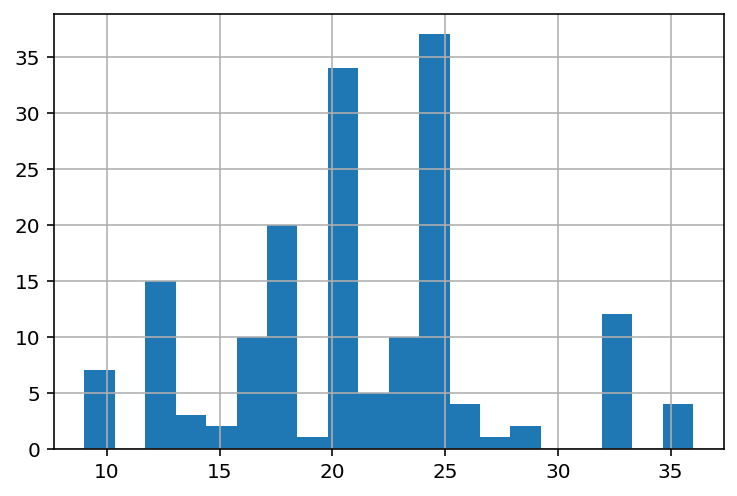

In [209]:
df2.sum_durs.hist(bins = 20)

In [218]:
# mask out short soggetti

df2 = df2[df2["sum_durs"] >= 15]


In [219]:
# compact view for inspection of relevant columns

df3 = df2[ready_classify]
df3.shape

(142, 9)

In [220]:
# run the classifier on the newly curated list of groups

classified2 = df3.applymap(lists_to_tuples_a).groupby("sub_group_id").apply(predict_type_a)

# drop the new singletons

# classified2.drop(classified2[classified2['predicted_type'] == "Singleton"].index, inplace = True)

# classified2 = classified2[classified2["predicted_type"] == "Fuga"]

classified2["start"] = classified2["start_measure"].astype(str) +"/"+ classified2["start_beat"].astype(str) 
classified2.drop(columns=['start_measure', 'start_beat','offset_diffs'], inplace=True)



In [221]:
# put things back in order by offset and group them again

classified2.sort_values(by = ["start_offset"], inplace=True)
c3 = classified2.groupby(by = ["sub_group_id"])
c3 = c3.head()

In [222]:
# Now transform as Pivot Table
pivot_c3 = c3.pivot_table(index=["piece_title", "pattern_matched", "predicted_type", "sub_group_id"],
            columns="entry_number",
            values=["part", "start_offset", "start"],
            aggfunc=lambda x: x)
pivot_c3_sort = pivot_c3.sort_values(by = [("start_offset", 1)])
pivot_c3_sort = pivot_c3_sort.fillna("-")
pivot_c3_sort.head()


part  \
entry_number                                                          1   
piece_title pattern_matched     predicted_type sub_group_id               
Ave Maria   [4, 1, 2, 2, -3]    PEN            55.0          [Superius]   
            [-2, -2, -2, 2, -2] PEN            7.0           [Superius]   
            [-2, -2, -2, 2, 2]  Singleton      8.0               Bassus   
            [1, 1, 2, 2, -3]    PEN            21.0          [Superius]   
            [2, 2, -3, -2, -2]  Singleton      46.0          [Superius]   

                                                                           \
entry_number                                                     2      3   
piece_title pattern_matched     predicted_type sub_group_id                 
Ave Maria   [4, 1, 2, 2, -3]    PEN            55.0          Altus  Tenor   
            [-2, -2, -2, 2, -2] PEN            7.0           Altus  Tenor   
            [-2, -2, -2, 2, 2]  Singleton      8.0               -      -   
            [1, 1, 2, 2, -3]    PEN            21.0          Altus  Tenor   
            [2, 2, -3, -2, -2]  Singleton      46.0              -      -   

                                                                        \
entry_number                                                      4  5   
piece_title pattern_matched     predicted_type sub_group_id              
Ave Maria   [4, 1, 2, 2, -3]    PEN            55.0          Bassus  -   
            [-2, -2, -2, 2, -2] PEN            7.0                -  -   
            [-2, -2, -2, 2, 2]  Singleton      8.0                -  -   
            [1, 1, 2, 2, -3]    PEN            21.0          Bassus  -   
            [2, 2, -3, -2, -2]  Singleton      46.0               -  -   

                                                              start          \
entry_number                                                      1       2   
piece_title pattern_matched     predicted_type sub_group_id                   
Ave Maria   [4, 1, 2, 2, -3]    PEN            55.0           1/1.0   3/1.0   
            [-2, -2, -2, 2, -2] PEN            7.0            8/1.0  10/1.0   
            [-2, -2, -2, 2, 2]  Singleton      8.0           14/1.0       -   
            [1, 1, 2, 2, -3]    PEN            21.0          16/3.0  18/3.0   
            [2, 2, -3, -2, -2]  Singleton      46.0          17/3.0       -   

                                                                             \
entry_number                                                      3       4   
piece_title pattern_matched     predicted_type sub_group_id                   
Ave Maria   [4, 1, 2, 2, -3]    PEN            55.0           5/1.0   7/1.0   
            [-2, -2, -2, 2, -2] PEN            7.0           12/1.0       -   
            [-2, -2, -2, 2, 2]  Singleton      8.0                -       -   
            [1, 1, 2, 2, -3]    PEN            21.0          20/3.0  22/3.0   
            [2, 2, -3, -2, -2]  Singleton      46.0               -       -   

                                                               start_offset  \
entry_number                                                 5            1   
piece_title pattern_matched     predicted_type sub_group_id                   
Ave Maria   [4, 1, 2, 2, -3]    PEN            55.0          -          0.0   
            [-2, -2, -2, 2, -2] PEN            7.0           -         56.0   
            [-2, -2, -2, 2, 2]  Singleton      8.0           -        104.0   
            [1, 1, 2, 2, -3]    PEN            21.0          -        124.0   
            [2, 2, -3, -2, -2]  Singleton      46.0          -        132.0   

                                                                               
entry_number                                                   2    3    4  5  
piece_title pattern_matched     predicted_type sub_group_id                    
Ave Maria   [4, 1, 2, 2, -3]    PEN            55.0           16   32   48  -  
            [-2, -2, -2, 2, -2] PEN  

In [223]:
pivot_c3_sort.reset_index(inplace=True)
pivot_c3_sort = pivot_c3_sort.drop(columns=['start_offset', "sub_group_id"])
pivot_c3_sort.head(50)
# pivot_c3.shape



piece_title       pattern_matched predicted_type        part  \
entry_number                                                            1   
0              Ave Maria      [4, 1, 2, 2, -3]            PEN  [Superius]   
1              Ave Maria   [-2, -2, -2, 2, -2]            PEN  [Superius]   
2              Ave Maria    [-2, -2, -2, 2, 2]      Singleton      Bassus   
3              Ave Maria      [1, 1, 2, 2, -3]            PEN  [Superius]   
4              Ave Maria    [2, 2, -3, -2, -2]      Singleton  [Superius]   
5              Ave Maria  [-2, -2, -2, -2, -2]      Singleton  [Superius]   
6              Ave Maria    [-2, -2, 2, 2, -2]      Singleton       Tenor   
7              Ave Maria      [2, 2, 1, 2, -2]           Fuga  [Superius]   
8              Ave Maria     [2, 1, 2, -2, -2]           Fuga       Altus   
9              Ave Maria     [1, 2, -2, 1, -2]           Fuga  [Superius]   
10             Ave Maria    [1, 2, -2, -2, -2]            PEN       Altus   
11             Ave Maria     [2, -2, 1, -2, 2]           Fuga  [Superius]   
12             Ave Maria     [1, 1, 2, -2, -2]      Singleton  [Superius]   
13             Ave Maria   [2, -2, -2, -2, -2]      Singleton  [Superius]   
14             Ave Maria  [-2, -2, -2, -2, -3]      Singleton  [Superius]   
15             Ave Maria     [-3, 2, 2, 2, -3]           Fuga  [Superius]   
16             Ave Maria      [2, 2, 2, -3, 2]           Fuga  [Superius]   
17             Ave Maria      [2, 2, -3, 2, 2]             ID       Tenor   
18             Ave Maria      [2, -3, 2, 2, 2]             ID       Tenor   
19             Ave Maria      [2, 2, 2, -2, 2]           Fuga  [Superius]   
20             Ave Maria     [2, -2, 2, -3, 2]           Fuga      Bassus   
21             Ave Maria    [2, -2, -2, -2, 2]      Singleton  [Superius]   
22             Ave Maria     [4, -2, 2, 2, -3]             ID  [Superius]   
23             Ave Maria    [-2, 2, 2, -3, -2]             ID  [Superius]   
24             Ave Maria    [2, 2, -3, -2, -2]             ID  [Superius]   
25             Ave Maria    [2, -3, -2, -2, 1]             ID  [Superius]   
26             Ave Maria     [2, -3, 2, -3, 2]           Fuga  [Superius]   
27             Ave Maria    [-3, 2, -3, 2, -2]             ID  [Superius]   
28             Ave Maria    [2, -3, 2, -2, -2]             ID  [Superius]   
29             Ave Maria   [-3, 2, -2, -2, -2]           Fuga  [Superius]   
30             Ave Maria   [2, -2, -2, -2, -2]      Singleton       Altus   
31             Ave Maria    [2, -3, 2, -2, -2]           Fuga  [Superius]   
32             Ave Maria     [1, 2, -2, 1, -2]           Fuga       Altus   
33             Ave Maria     [2, -2, 1, -2, 2]           Fuga       Altus   
34             Ave Maria       [1, 1, 2, 1, 2]             ID  [Superius]   
35             Ave Maria     [1, 1, 2, -2, -2]           Fuga       Altus   
36             Ave Maria       [1, 2, 1, 2, 1]             ID  [Superius]   
37             Ave Maria    [1, 2, -2, -2, -2]           Fuga       Altus   
38             Ave Maria      [2, 1, 2, 1, -3]             ID  [Superius]   
39             Ave Maria   [2, -2, -2, -2, -2]           Fuga       Altus   
40             Ave Maria   [-2, -2, -2, -2, 1]           Fuga       Altus   
41             Ave Maria   [-2, -2, -2, -2, 1]           Fuga  [Superius]   
42             Ave Maria     [1, 1, 2, -2, -2]             ID  [Superius]   
43             Ave Maria    [1, 2, -2, -2, -2]             ID  [Superius]   
44             Ave Maria    [2, -2, -2, -2, 1]             ID  [Superius]   
45             Ave Maria    [-2, -2, -2, 1, 3]             ID  [Superius]   
46             Ave Maria    [1, 3, -2, -2, -2]             ID  [Superius]   
47             Ave Maria   [3, -2, -2, -2, -2]             ID  [Superius]   
48             Ave Maria      [2, 2, 2, -2, 2]           Fuga  [Superius]   
49             Ave Maria   [-2, -2, -2, -2, 2]      Singleton      Bassus   

        